In [1]:
# ============================================================================
# STEP 1: ENVIRONMENT SETUP
# ============================================================================
# Load environment variables and initialize Google Earth Engine

from dotenv import load_dotenv
load_dotenv()

import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [2]:
# ============================================================================
# STEP 2: LOAD AREA OF INTEREST (AOI) but only on the AOI concession
# ============================================================================
# Load the area of interest geometry for reference

from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee('./00_input/korindo_buffer.shp')

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

✅ AOI loaded: 1 features
   Area: 40740.66 hectares


In [3]:
## save data
zarr_path = 'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_features_all_aoi.zarr'

ds_ml_aoi = load_dataset_zarr(
    zarr_path,
)
ds_ml_aoi

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_features_all_aoi.zarr
✅ Dataset loaded: {'sample': 4073658, 'features': 197}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 7GB
Dimensions:     (sample: 4073658, features: 197)
Coordinates:
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
  * sample      (sample) int64 33MB 0 1 2 3 ... 4073654 4073655 4073656 4073657
Data variables:
    coord_x     (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y     (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id     (sample) object 33MB dask.array<chunksize=(509208,), meta=np.ndarray>
    X_features  (sample, features) float64 6GB dask.array<chunksize=(100000, 197), meta=np.ndarray>

In [4]:
import os
import json
from google.cloud import storage
from catboost import CatBoostClassifier

use_output_prediction = True

model = 'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/catboost_20251204_041716.cbm'
config = 'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/config_20251204_041716.json'

zarr_path = 'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_aoi.zarr'

def download_blob(gcs_uri, local_filename):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    
    # Parse the gs:// URI
    parts = gcs_uri.replace("gs://", "").split("/", 1)
    bucket_name = parts[0]
    blob_name = parts[1]
    
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.download_to_filename(local_filename)
    print(f"Downloaded {gcs_uri} to {local_filename}")

if use_output_prediction != True:

    # 2. Download files locally
    # CatBoost needs a local file to load the model efficiently
    local_model_file = '/mnt/data/catboost_20251204_041716.cbm'
    local_config_file = '/mnt/data/config_20251204_041716.json'

    download_blob(model, local_model_file)
    download_blob(config, local_config_file)

    # 3. Load the Config (JSON)
    with open(local_config_file, 'r') as f:
        config_data = json.load(f)
        print("Config loaded.")

    # 4. Load the CatBoost Model
    # Note: Ensure you use the same class (Classifier/Regressor) used during training
    model = CatBoostClassifier() # Change to CatBoostRegressor() if your target is continuous
    model.load_model(local_model_file)

    # 5. Prepare Data and Predict
    # Assuming ds_ml_aoi is already defined in your environment
    X_all = ds_ml_aoi.X_features.values

    # CRITICAL FIX: You predict using the 'model' object, not the 'config'
    y_pred = model.predict(X_all)

    print("Predictions shape:", y_pred.shape)

    ds_ml_aoi['y_pred'] = (('sample'), y_pred)
    # ds_ml_aoi
    # save first before cleaning
    
    chunk = {'sample':100000}
    save_dataset_efficient_zarr(ds_ml_aoi, zarr_path, chunk_sizes=chunk, overwrite=True)

else:
    ds_ml_aoi = load_dataset_zarr(zarr_path)
    # ds_ml_aoi



📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_aoi.zarr
✅ Dataset loaded: {'sample': 4073658, 'features': 197}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:855: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [5]:
ds_ml_aoi

<xarray.Dataset> Size: 7GB
Dimensions:     (sample: 4073658, features: 197)
Coordinates:
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
  * sample      (sample) int64 33MB 0 1 2 3 ... 4073654 4073655 4073656 4073657
Data variables:
    coord_x     (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y     (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id     (sample) object 33MB dask.array<chunksize=(509208,), meta=np.ndarray>
    X_features  (sample, features) float64 6GB dask.array<chunksize=(100000, 197), meta=np.ndarray>
    y_pred      (sample) int64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>

In [6]:
print(ds_ml_aoi)

<xarray.Dataset> Size: 7GB
Dimensions:     (sample: 4073658, features: 197)
Coordinates:
  * features    (features) <U68 54kB 'EVI__fft_coefficient__attr_"angle"__coe...
  * sample      (sample) int64 33MB 0 1 2 3 ... 4073654 4073655 4073656 4073657
Data variables:
    coord_x     (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y     (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id     (sample) object 33MB dask.array<chunksize=(509208,), meta=np.ndarray>
    X_features  (sample, features) float64 6GB dask.array<chunksize=(100000, 197), meta=np.ndarray>
    y_pred      (sample) int64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>


In [9]:
# ============================================================
#   MMU CLEANING FOR A SINGLE-PLOT DATASET (~4M samples)
#   Removes small objects and merges to majority neighbors
#   With tqdm PROGRESS BAR
# ============================================================

import numpy as np
import xarray as xr
from scipy.ndimage import label as ndi_label, binary_dilation
from tqdm import tqdm
import math

# ---------------- CONFIG ----------------
ds = ds_ml_aoi
pred_name = "y_pred"
coord_x_name = "coord_x"
coord_y_name = "coord_y"
sample_dim = "sample"
min_area_ha = 0.25
connectivity = 2
dilate_iterations = 1

# ---------------- SAFE LOADING ----------------
def to_numpy(a):
    """Convert dask or numpy array safely to numpy."""
    try:
        return a.compute()
    except AttributeError:
        return np.asarray(a)

coord_x = to_numpy(ds[coord_x_name].data)
coord_y = to_numpy(ds[coord_y_name].data)
preds   = to_numpy(ds[pred_name].data)
samples = to_numpy(ds[sample_dim].data)

n = preds.shape[0]
assert len(coord_x) == n and len(coord_y) == n and len(samples) == n

# ---------------- BUILD GRID ----------------
x_u = np.unique(coord_x)
y_u = np.unique(coord_y)
nx = len(x_u)
ny = len(y_u)
print(f"Grid: ny={ny}, nx={nx}, total={ny*nx:,} cells; samples={n:,}")

x_idx = np.searchsorted(x_u, coord_x)
y_idx = np.searchsorted(y_u, coord_y)

grid_size = nx * ny
SENT = -99999999

pred_grid_flat   = np.full(grid_size, SENT, dtype=np.int64)
sample_grid_flat = np.full(grid_size, -1,  dtype=np.int64)

flat_idx = y_idx * nx + x_idx
pred_grid_flat[flat_idx]   = preds
sample_grid_flat[flat_idx] = samples

pred_grid   = pred_grid_flat.reshape((ny, nx))
sample_grid = sample_grid_flat.reshape((ny, nx))
valid_mask  = sample_grid != -1
print("Valid cells:", valid_mask.sum())

# ---------------- MMU THRESHOLD ----------------
dx = float(np.diff(x_u).mean()) if len(x_u) > 1 else 10.0
dy = float(np.diff(y_u).mean()) if len(y_u) > 1 else 10.0
pixel_area_ha = abs(dx*dy) / 10000.0
min_pixels = int(math.ceil(min_area_ha / pixel_area_ha))
print(f"Pixel {dx:.2f}×{dy:.2f} m ({pixel_area_ha:.5f} ha) -> min_pixels = {min_pixels}")

# ---------------- CLEANING (with PROGRESS BAR) ----------------
cleaned = pred_grid.copy()
classes = np.unique(pred_grid[valid_mask])
print("Classes:", classes)

struct = np.ones((3,3), dtype=bool)

for cls in tqdm(classes, desc="MMU cleaning", ncols=80):
    cls_mask = (cleaned == cls) & valid_mask
    if not np.any(cls_mask):
        continue

    labels, num = ndi_label(cls_mask, structure=struct)
    if num == 0:
        continue

    comp_ids, counts = np.unique(labels[labels > 0], return_counts=True)
    small_ids = comp_ids[counts < min_pixels]
    if len(small_ids) == 0:
        continue

    for sid in small_ids:
        comp_mask = (labels == sid)
        neigh_mask = binary_dilation(comp_mask, iterations=dilate_iterations, structure=struct)
        neigh_mask = neigh_mask & (~comp_mask) & valid_mask

        if not np.any(neigh_mask):
            continue  # isolated small patch stays

        neigh_vals = cleaned[neigh_mask]
        vals, cnts = np.unique(neigh_vals, return_counts=True)
        mode_val = vals[np.argmax(cnts)]
        cleaned[comp_mask] = mode_val

# ---------------- MAP BACK TO 1D ----------------
final_clean = np.full(n, fill_value=SENT, dtype=preds.dtype)

present_mask = sample_grid != -1
present_samples = sample_grid[present_mask]
present_values  = cleaned[present_mask].astype(preds.dtype)

final_clean[present_samples] = present_values

miss = final_clean == SENT
if np.any(miss):
    final_clean[miss] = preds[miss]

# ---------------- ATTACH TO DATASET ----------------
ds = ds.copy()
ds["eligibility_clean"] = (sample_dim, final_clean.astype(preds.dtype))
print("✅ Done. Added ds['eligibility_clean']")


Grid: ny=2907, nx=4489, total=13,049,523 cells; samples=4,073,658
Valid cells: 4073658
Pixel 10.00×11.05 m (0.01105 ha) -> min_pixels = 23
Classes: [0 1]


MMU cleaning: 100%|███████████████████████████| 2/2 [1:59:24<00:00, 3582.29s/it]


✅ Done. Added ds['eligibility_clean']


In [10]:
ds

<xarray.Dataset> Size: 7GB
Dimensions:            (sample: 4073658, features: 197)
Coordinates:
  * features           (features) <U68 54kB 'EVI__fft_coefficient__attr_"angl...
  * sample             (sample) int64 33MB 0 1 2 3 ... 4073655 4073656 4073657
Data variables:
    coord_x            (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y            (sample) float64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id            (sample) object 33MB dask.array<chunksize=(509208,), meta=np.ndarray>
    X_features         (sample, features) float64 6GB dask.array<chunksize=(100000, 197), meta=np.ndarray>
    y_pred             (sample) int64 33MB dask.array<chunksize=(100000,), meta=np.ndarray>
    eligibility_clean  (sample) int64 33MB 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1

/tmp/ipykernel_309/3485448799.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n = ds.dims['sample']


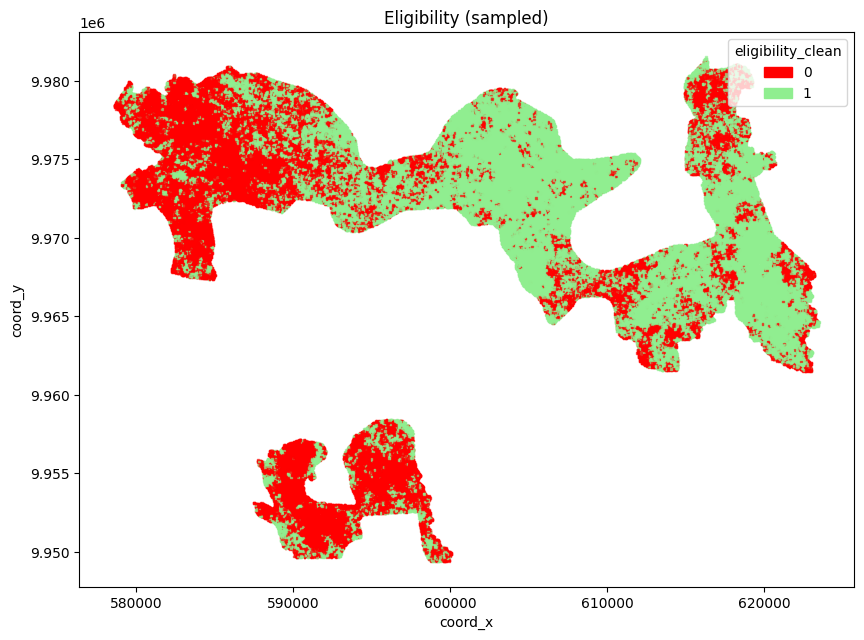

In [ ]:
# Quick map plot of eligibility_clean (0=red, 1=light green)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Sample to keep plotting light-weight; bump this up if you have memory headroom
sample_size = 200_000
n = ds.dims['sample']
take = min(sample_size, n)

rng = np.random.default_rng(42)
idx = rng.choice(n, size=take, replace=False)

subset = ds[['coord_x', 'coord_y', 'eligibility_clean']].isel(sample=idx).compute()
x = subset['coord_x'].values
y = subset['coord_y'].values
lbl = subset['eligibility_clean'].values

cmap = mcolors.ListedColormap(['red', 'lightgreen'])

plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=lbl, cmap=cmap, s=1, marker='s', alpha=0.6)
plt.gca().set_aspect('equal', 'box')
plt.xlabel('coord_x')
plt.ylabel('coord_y')
plt.title('Eligibility (sampled)')
plt.grid(False)

legend_handles = [
    mpatches.Patch(color='red', label='0'),
    mpatches.Patch(color='lightgreen', label='1'),
]
plt.legend(handles=legend_handles, title='eligibility_clean', loc='upper right')
plt.show()

In [12]:
## save dataset to zarr
zarr_path = 'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr'
save_dataset_efficient_zarr(ds, zarr_path, chunk_sizes={'sample':100000}, overwrite=True)

/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:641: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:710: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(ds.dims.keys())
GEE requires last two dimensions to be Y and X (spatial). Found: ['sample', 'features']. GEE may have issues loading this array.


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'sample': 4073658, 'features': 197}
   Chunks: {'sample': 100000}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[                                        ] | 0% Completed | 453.19 us

/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:729: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 2.01 sms
[########################################] | 100% Completed | 39.67 ss
✅ Dataset saved successfully!
   Store size: 4.66 GB
   Time: 47.4 seconds (0.8 minutes)
   Write speed: 100.8 MB/s
   Path: gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr


'gs://remote_sensing_saas/01-korindo/tsfresh_model_catboost/ds_pred_results_tsfresh_aoi.zarr'